In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = 't8btag_minmass'

In [5]:
# data = ObjIter([Tree(module.JetHT_Data_UL_List)])
signal = ObjIter([ Tree(f) for f in module.signal_list ])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


In [6]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)

t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)

In [7]:
signal = signal.apply(eightb.selected_jet_ptregressed())
bkg = bkg.apply(eightb.selected_jet_ptregressed())

In [8]:
signal = signal.apply(eightb.selected_jet_btagwp())
bkg = bkg.apply(eightb.selected_jet_btagwp())

In [9]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

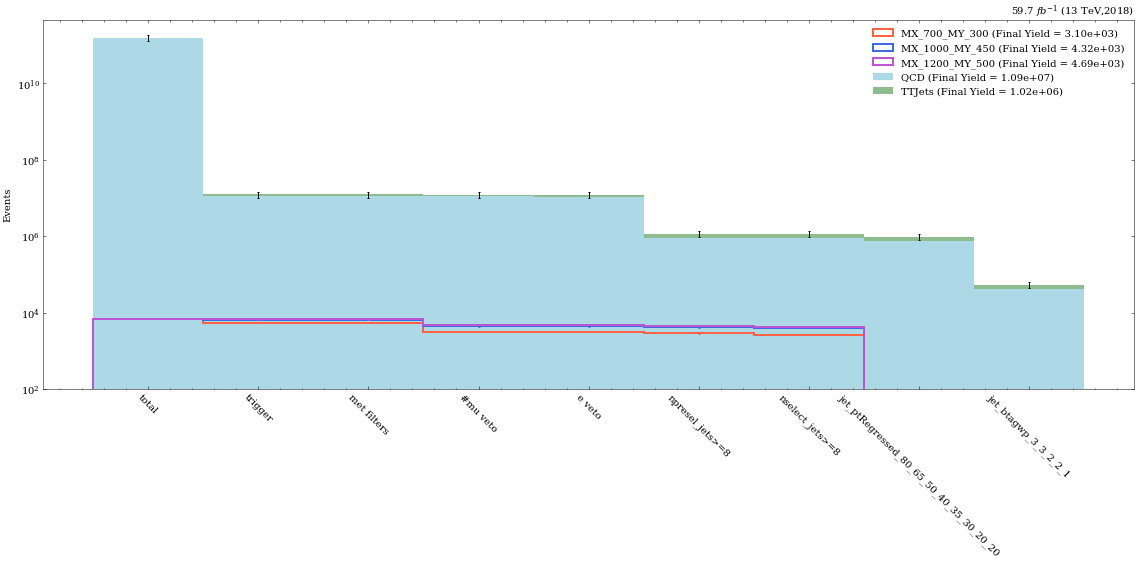

In [10]:
def get_efficiency(histo):
    print(histo)
    return 

study.cutflow(
    signal+bkg, legend=True, legend_loc="upper right",
    h_label_stat="Final Yield = {histo[4]:0.2e}",
    ylim=(1e2, -1), log=True,
    saveas="cutflow"
)

In [11]:
from collections import defaultdict
def get_sample_yields(t):
    lumi,_ = lumiMap[2018]
    class _sample:
        def __init__(self):
            self.yields = 0
            self.xsec = 0
    samples = defaultdict(_sample)
    for i, f in enumerate(t.filelist):
        mask = t.sample_id==i
        yields = ak.sum(t.scale[mask])*lumi

        samples[f.sample].yields += yields
        samples[f.sample].xsec = f.xsec

    for name, sample in samples.items():
        print(f'{name}, {sample.xsec}, {sample.yields}')
(signal+bkg).apply(get_sample_yields)

NMSSM_XYY_YToHH_8b, 0.11504969328885763, 2650.5668178562505
NMSSM_XYY_YToHH_8b, 0.11504969328885763, 3893.495259926948
NMSSM_XYY_YToHH_8b, 0.11504969328885763, 4307.823276719658
QCD_bEnriched_HT100to200, 1127000.0, 0.0
QCD_bEnriched_HT200to300, 80430.0, 730.1540425337923
QCD_bEnriched_HT300to500, 16620.0, 17042.557205605175
QCD_bEnriched_HT500to700, 1487.0, 16218.250933015595
QCD_bEnriched_HT700to1000, 296.5, 9145.728772642358
QCD_bEnriched_HT1000to1500, 46.61, 3190.534386356174
QCD_bEnriched_HT1500to2000, 3.72, 454.26198262502675
QCD_bEnriched_HT2000toInf, 0.6462, 103.81263314615266
QCD_HT100to200_BGenFilter, 1275000.0, 0.0
QCD_HT200to300_BGenFilter, 111700.0, 0.0
QCD_HT300to500_BGenFilter, 27960.0, 14670.196407303501
QCD_HT500to700_BGenFilter, 3078.0, 16842.488563141233
QCD_HT700to1000_BGenFilter, 721.8, 11356.24042253476
QCD_HT1000to1500_BGenFilter, 138.2, 5455.494886797544
QCD_HT1500to2000_BGenFilter, 13.61, 1141.4601147597702
QCD_HT2000toInf_BGenFilter, 2.92, 306.04876121019606
TT

[None, None, None, None, None]

100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


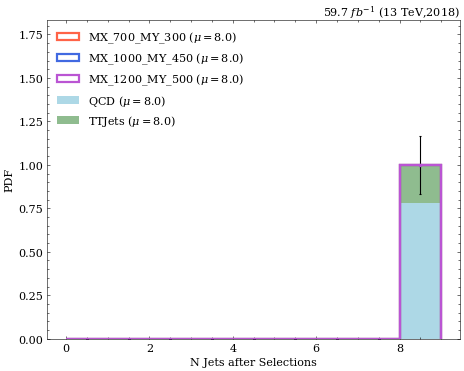

In [12]:
study.quick(
    signal+bkg, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['n_jet'],
    xlabels=['N Jets after Selections'],
    saveas=f'{dout}/n_presel_jets'
)

100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


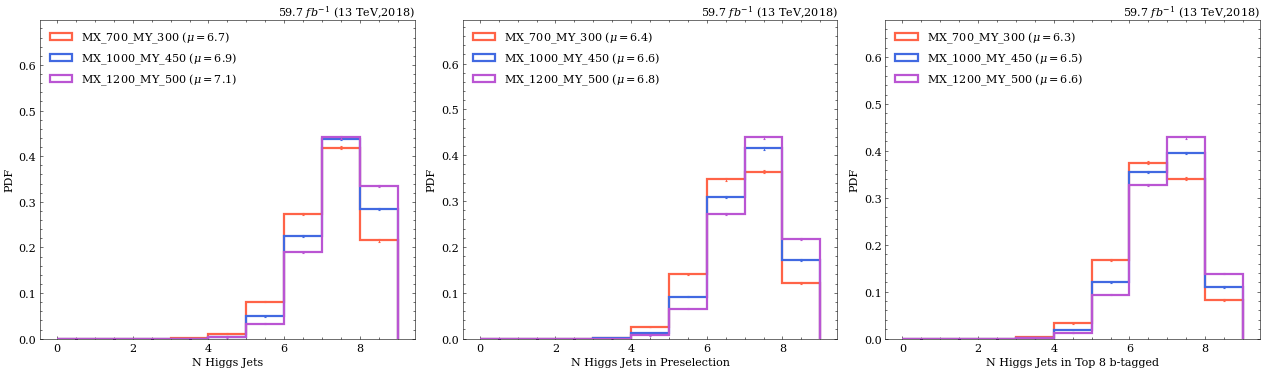

In [13]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['nfound_all','nfound_presel','nfound_select'],
    xlabels=['N Higgs Jets','N Higgs Jets in Preselection','N Higgs Jets in Top 8 b-tagged'],
    dim=-1,
    saveas=f'{dout}/n_higgs_jets'
)

In [14]:
njets_lost = lambda t:t.nfound_presel-t.nfound_select

def frac_events(t):
    nlost = njets_lost(t)
    return f"{ak.mean(nlost>0):0.2%}"

signal.apply(frac_events)

['13.84%', '17.28%', '18.93%']

100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


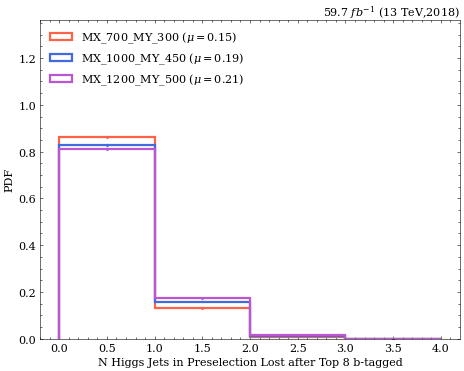

In [15]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    varlist=[njets_lost],
    xlabels=['N Higgs Jets in Preselection Lost after Top 8 b-tagged'],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/n_higgs_jets_lost'
)

100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


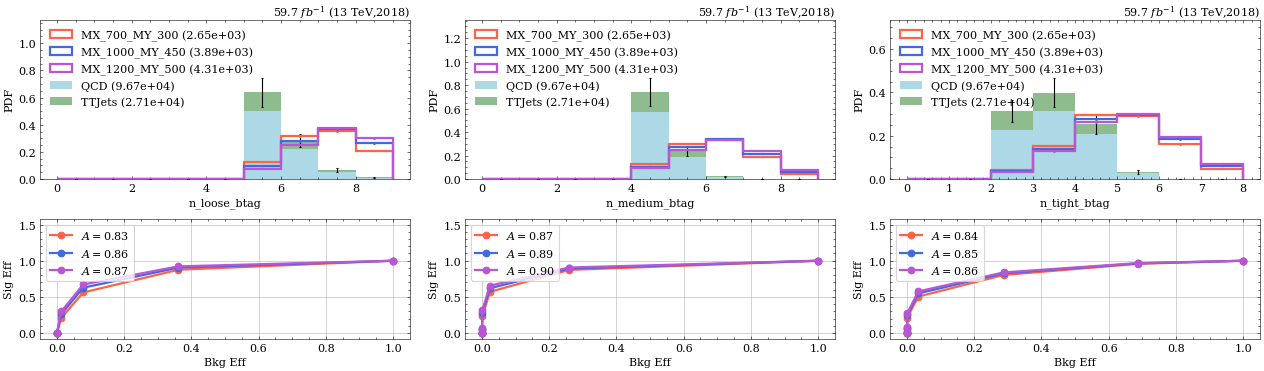

In [16]:
study.quick(
    bkg+signal, legend=True,
    # masks=lambda t:t.n_loose_btag==8,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    efficiency=True, dim=-1,
    **study.auroc,

    saveas=f'{dout}/btag_multi'
)

In [17]:

(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ordered='pt'))

[None, None, None, None, None]

100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


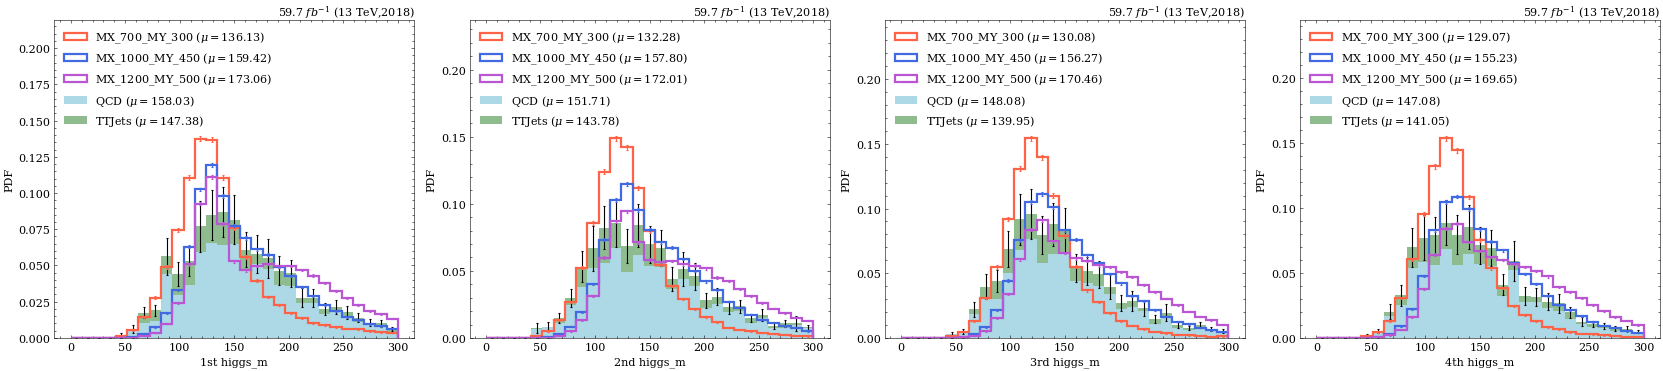

In [18]:
study.quick(
    signal+bkg,
    legend=True, h_label_stat='$\mu={stats.mean:0.2f}$',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m'
)

In [19]:
varinfo.jet_btag = dict(bins=(0,1,30))

100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


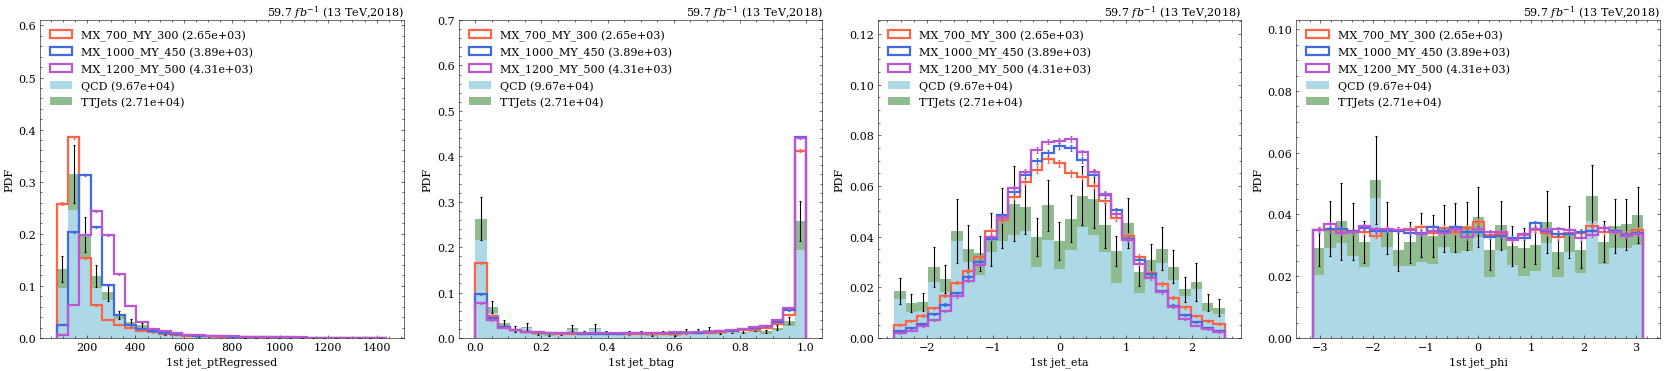

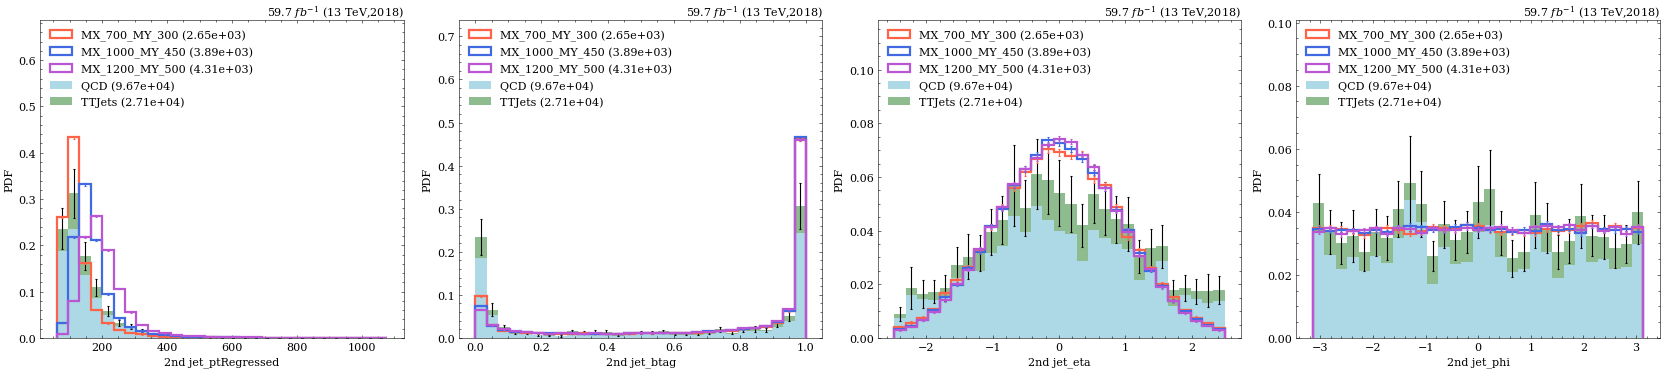

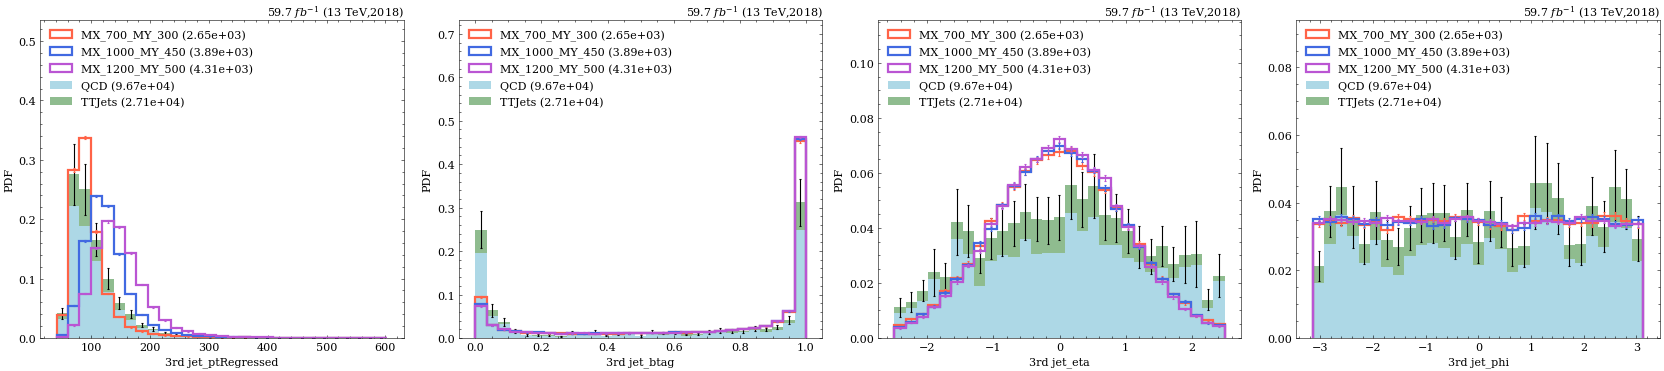

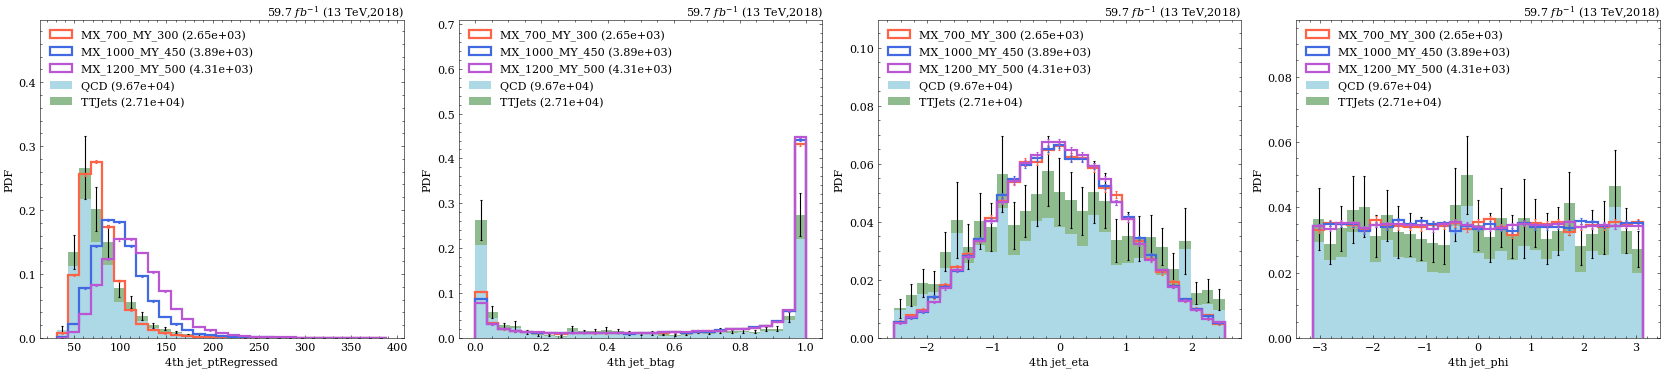

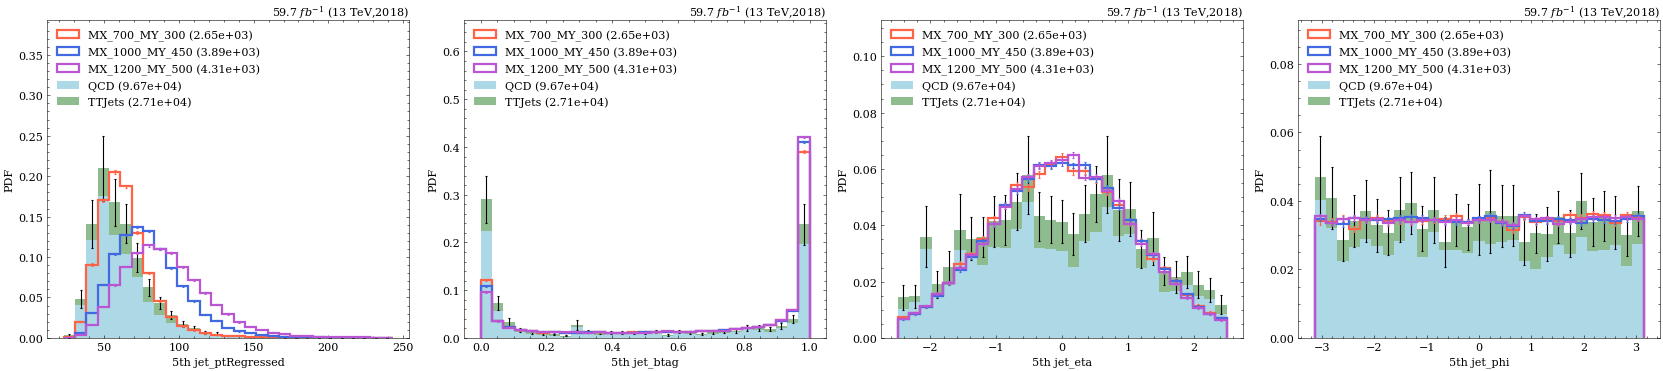

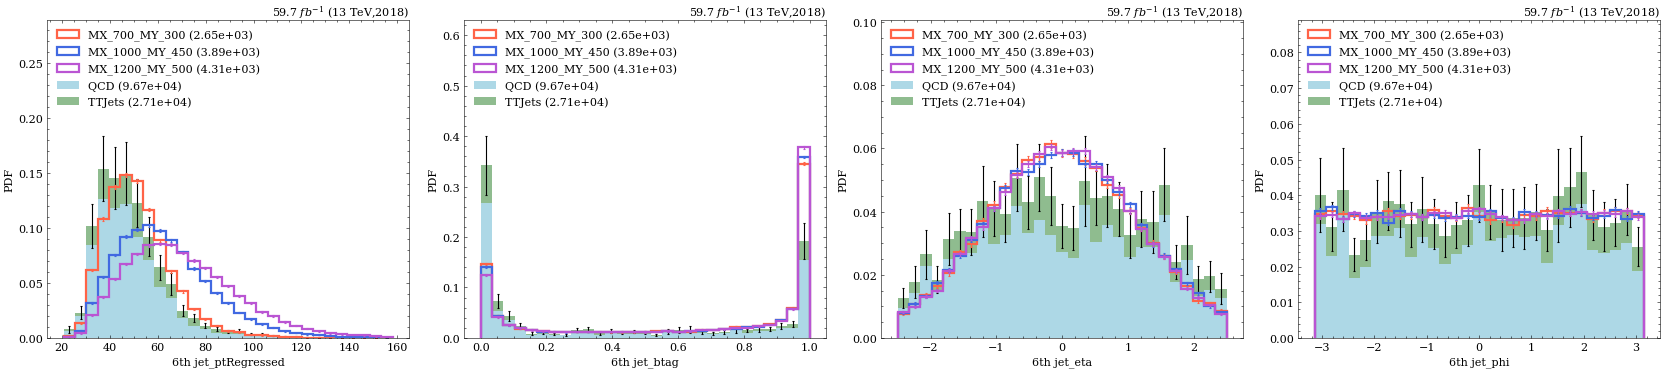

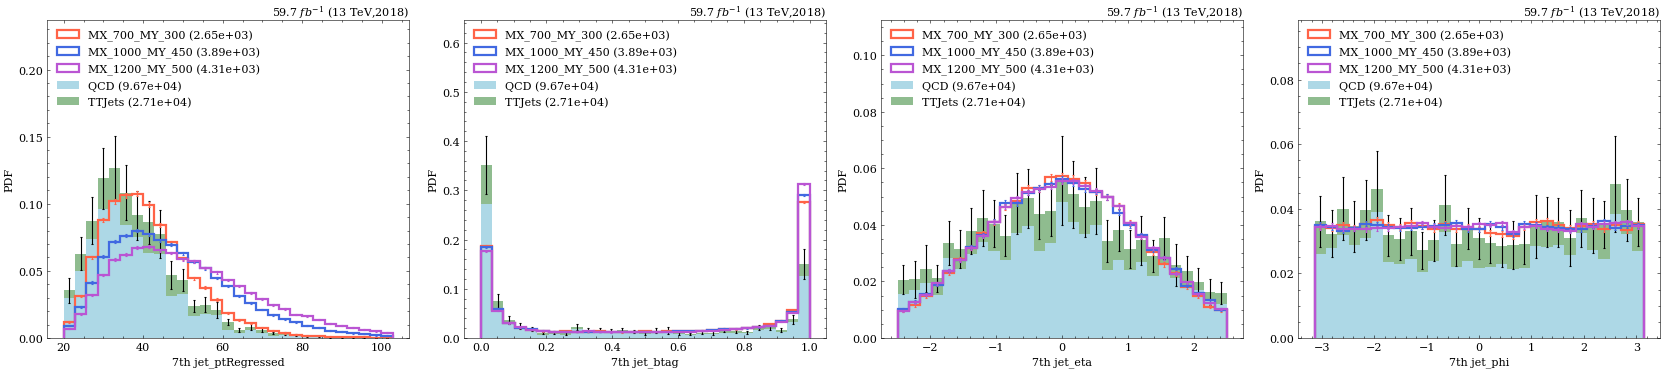

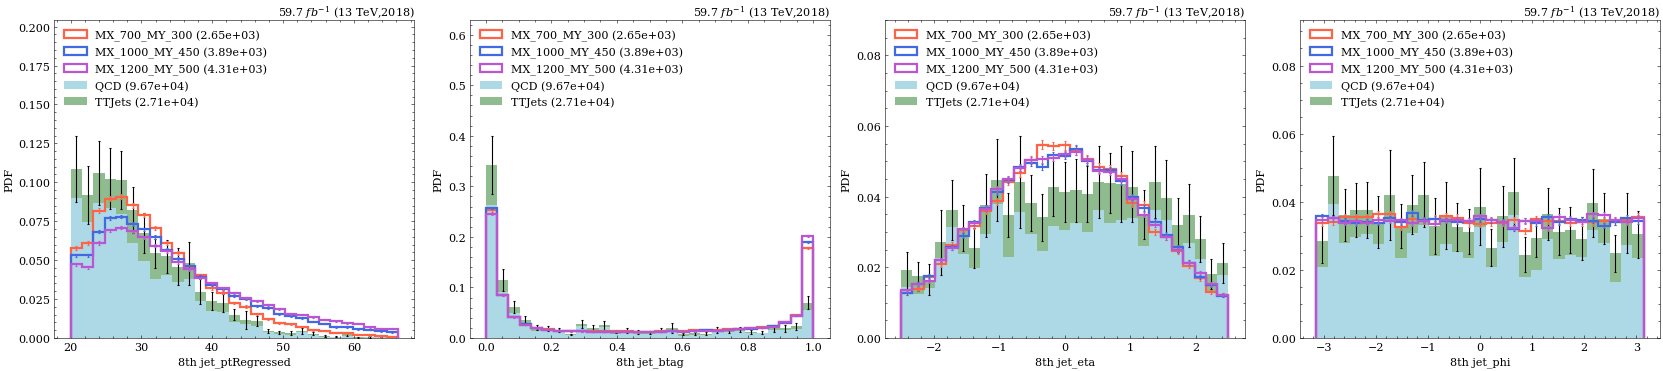

In [20]:
for i in range(8):
    study.quick( 
        signal+bkg, legend=True, 
        varlist=[f'jet_{var}[:,{i}]' for var in ('ptRegressed','btag','eta','phi')],
        efficiency=True,
        dim=-1,
        saveas=f'{dout}/{ordinal(i)}_pt_jet'
    )

In [21]:
varinfo.higgs_m = dict(bins=(0,500,30))

100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


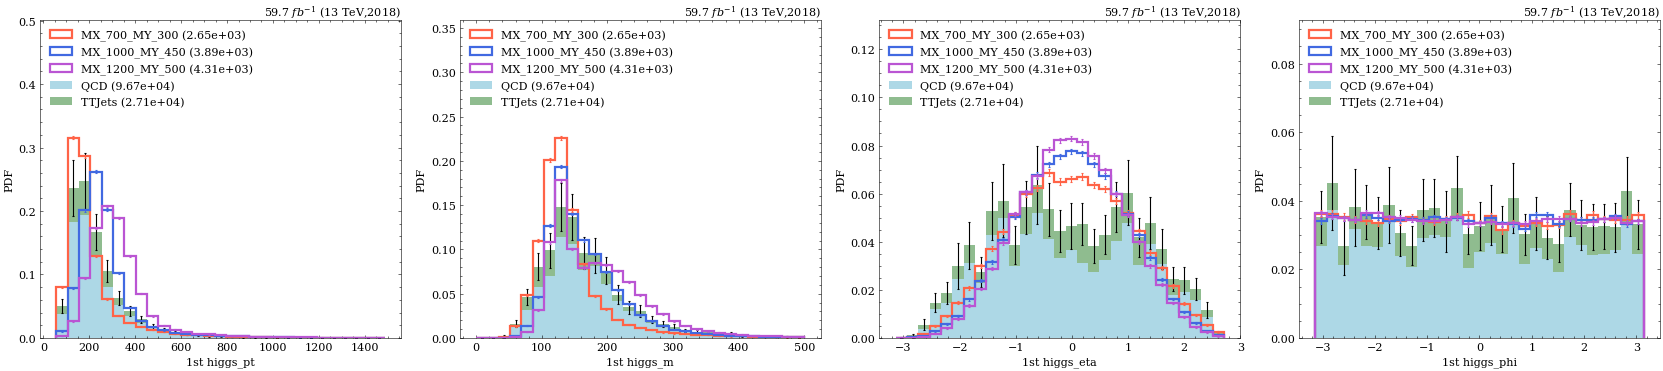

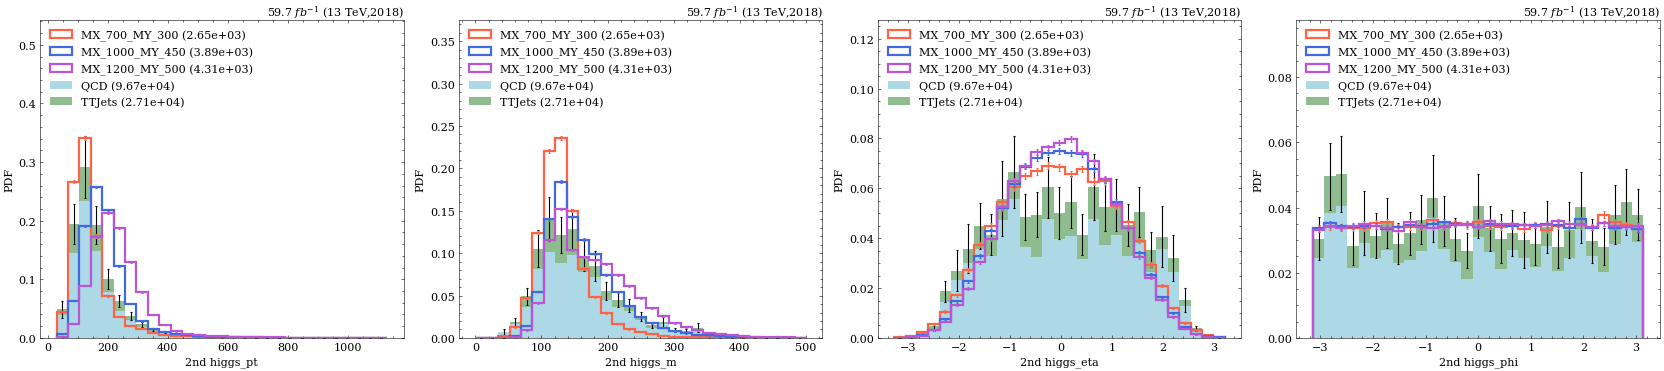

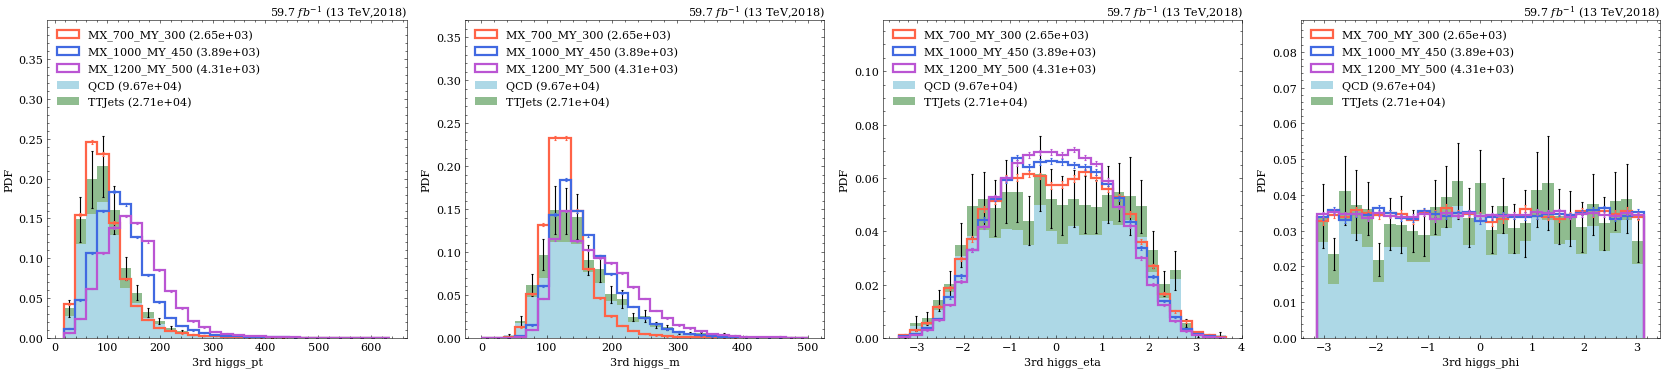

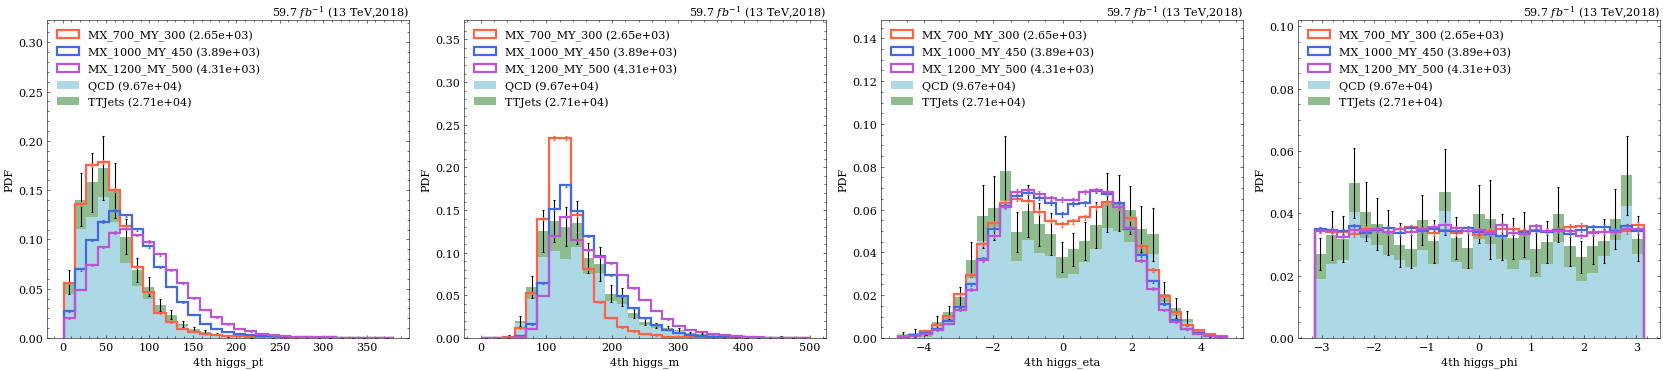

In [22]:
for i in range(4):
    study.quick( 
        signal+bkg, legend=True, efficiency=True,
        varlist=[f'higgs_{var}[:,{i}]' for var in ('pt','m','eta','phi')],
        dim=-1,
        saveas=f'{ordinal(i)}_pt_higgs'
    )

In [23]:
varinfo.Y1_m = dict(bins=(0,1000,30))
varinfo.Y2_m = dict(bins=(0,1000,30))


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


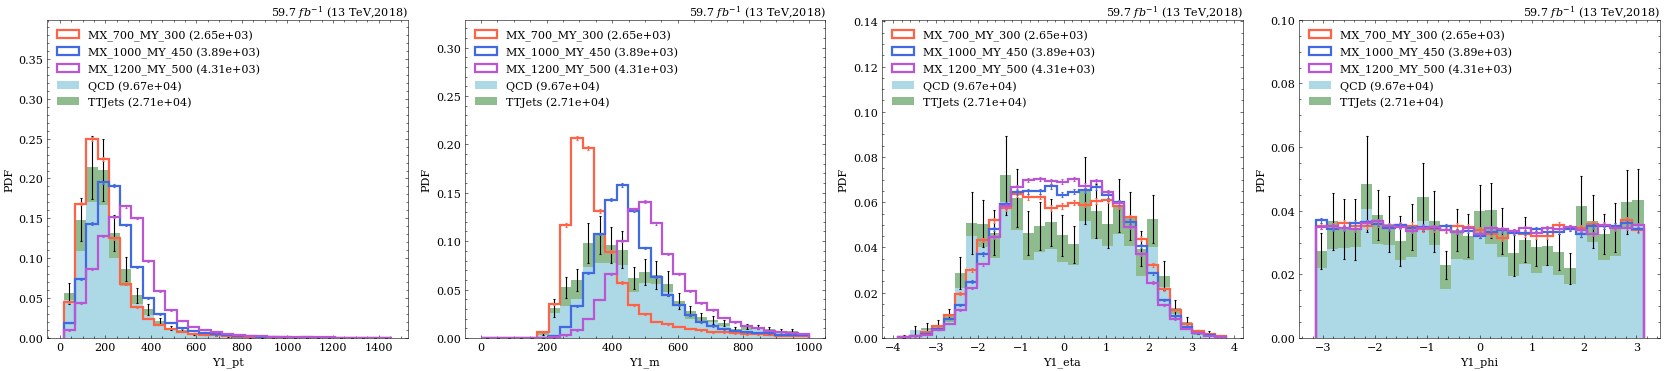

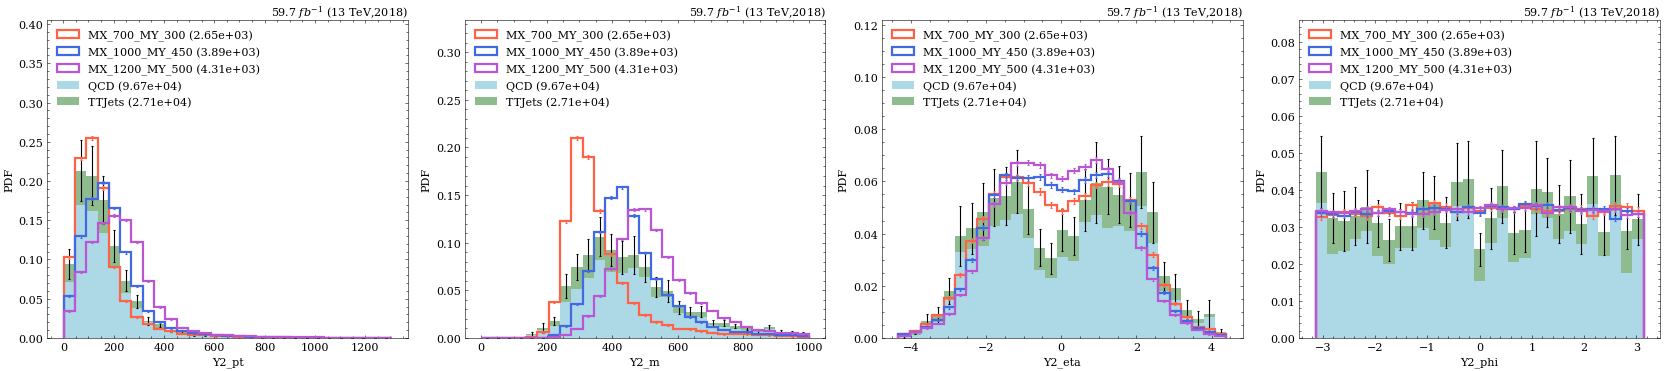

In [24]:
for i in range(2):
    study.quick( 
        signal+bkg, legend=True, efficiency=True,
        varlist=[f'Y{i+1}_{var}' for var in ('pt','m','eta','phi')],
        dim=-1,
        saveas=f'{dout}/{ordinal(i)}_pt_y'
    )

In [25]:
varinfo.X_m = dict(bins=(500,2000,15))

100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


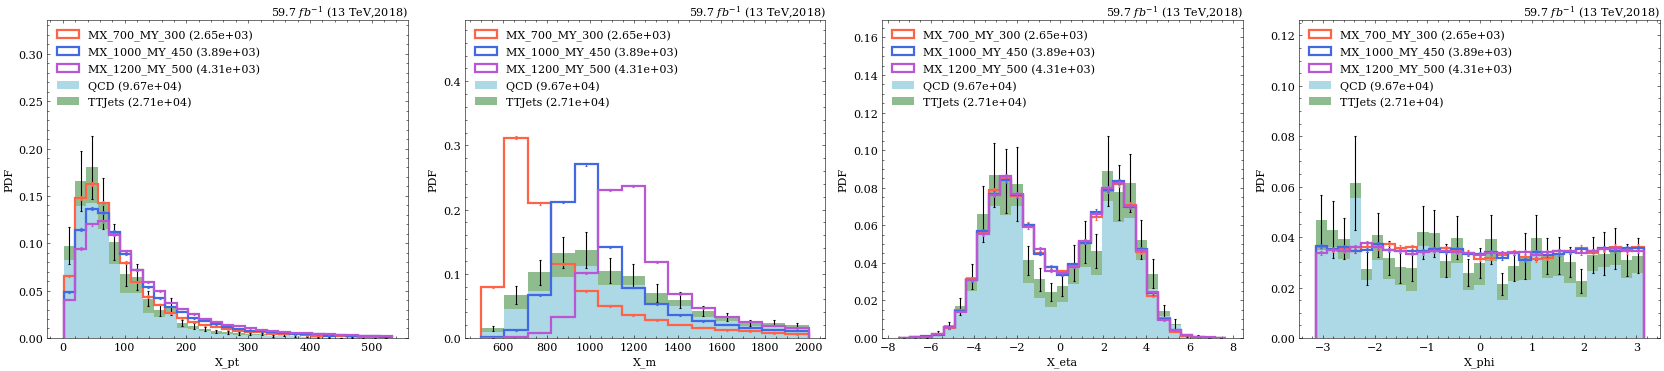

In [26]:
study.quick( 
    signal+bkg, legend=True, efficiency=True,
    varlist=[f'X_{var}' for var in ('pt','m','eta','phi')],
    dim=-1,
    saveas=f'{dout}/X'
)

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


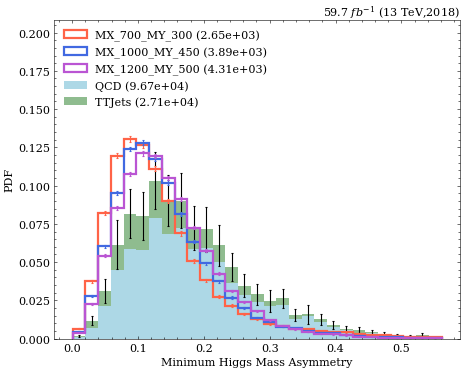

In [27]:
def hm_asym(t):
    hm = np.abs(t.higgs_m)
    hm_max, hm_min = ak.max(hm, axis=-1), ak.min(hm, axis=-1)
    asym = (hm_max-hm_min)/(hm_max+hm_min)
    t.extend(hm_asym=asym)
    return asym

study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[hm_asym],
    xlabels=['Minimum Higgs Mass Asymmetry'],
    saveas=f'{dout}/hm_asym',
)

100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


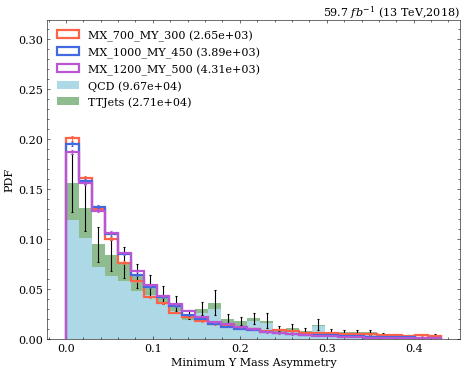

In [28]:
def ym_asym(t):
    ym = ak_stack([t.Y1_m, t.Y2_m])
    ym_max, ym_min = ak.max(ym, axis=-1), ak.min(ym, axis=-1)
    asym = (ym_max-ym_min)/(ym_max+ym_min)
    t.extend(ym_asym=asym)
    return asym

study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[ym_asym],
    xlabels=['Minimum Y Mass Asymmetry'],
    saveas=f'{dout}/ym_asym',
)

100%|██████████| 1/1 [00:16<00:00, 16.44s/it]


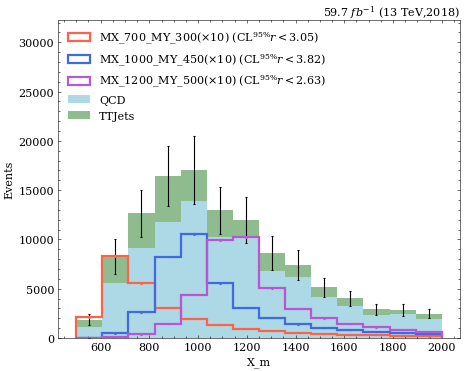

In [29]:
study.quick(
    signal+bkg, legend=True,
    # scale=[100]*len(signal),
    plot_scale=[10]*len(signal),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/no_cuts'
)

100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


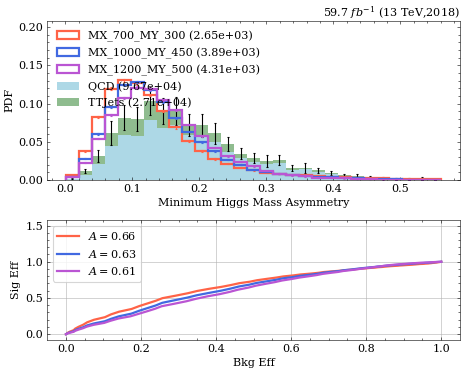

In [30]:
study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[hm_asym],
    xlabels=['Minimum Higgs Mass Asymmetry'],

    **study.auroc,
    saveas=f'{dout}/hm_asym_roc',
)

100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


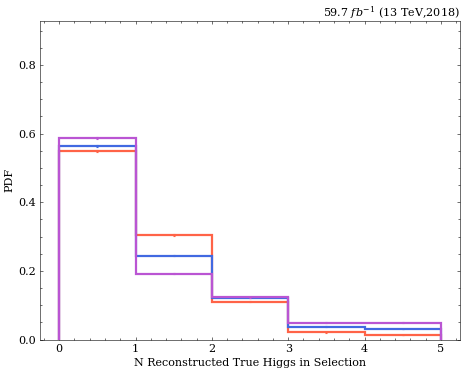

In [31]:
study.quick(
    signal,
    varlist=['nfound_paired_h'],
    efficiency=True,
    xlabels=['N Reconstructed True Higgs in Selection']
)

100%|██████████| 1/1 [00:06<00:00,  6.44s/it]


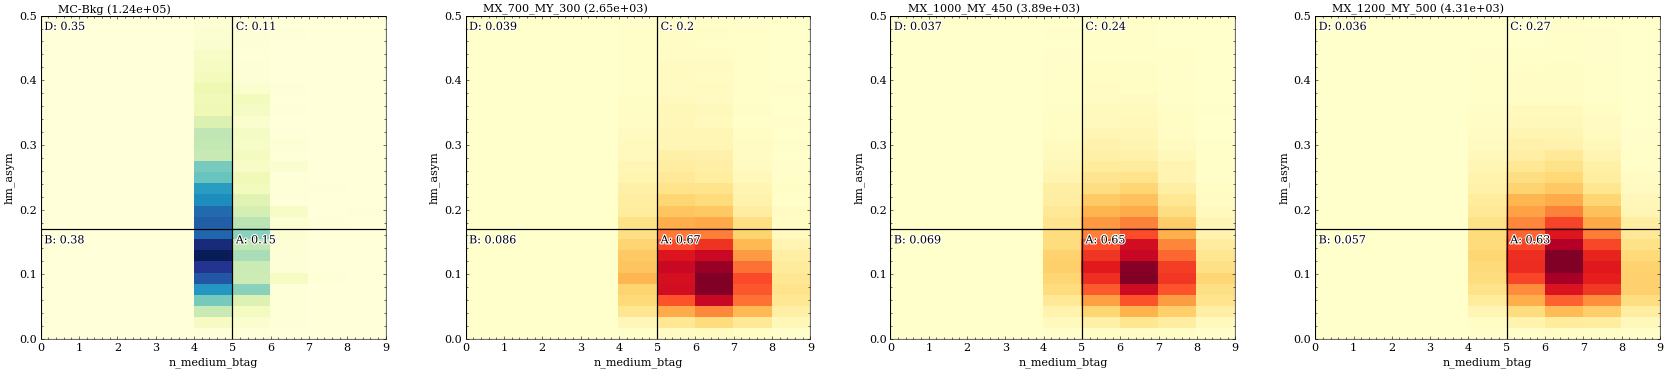

In [32]:
study.quick2d(
    signal+bkg,
    varlist=['n_medium_btag','hm_asym'],
    binlist=[None, (0,0.5,30)],
    exe=draw_abcd(x_r=(0,5,9),y_r=(0,0.17,0.5), regions=["C","D","A","B"]),
    saveas=f'{dout}/limits/abcd_loose_btag_vs_hm_asym'
)

In [33]:
def event_variables(t):
    t.extend(
        jet_ht = ak.sum(t.jet_ptRegressed,axis=-1)
    )
(signal+bkg).apply(event_variables)

bdt = ABCD(
    features=['jet_ht','higgs_m[:,0]'],
    a = lambda t : (t.n_medium_btag >= 5) &                         (t.hm_asym < 0.17),
    b = lambda t : (t.n_medium_btag >= 2) & (t.n_medium_btag < 5) & (t.hm_asym < 0.17),
    c = lambda t : (t.n_medium_btag >= 5) &                         (t.hm_asym > 0.17),
    d = lambda t : (t.n_medium_btag >= 2) & (t.n_medium_btag < 5) & (t.hm_asym > 0.17),
)

100%|██████████| 1/1 [00:14<00:00, 14.12s/it]


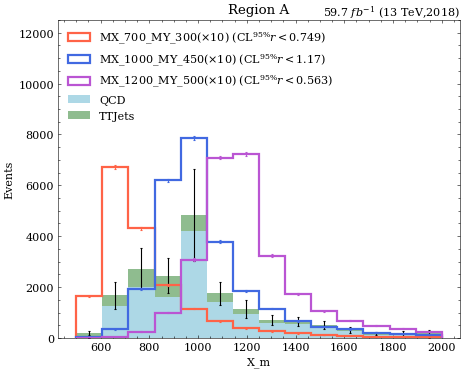

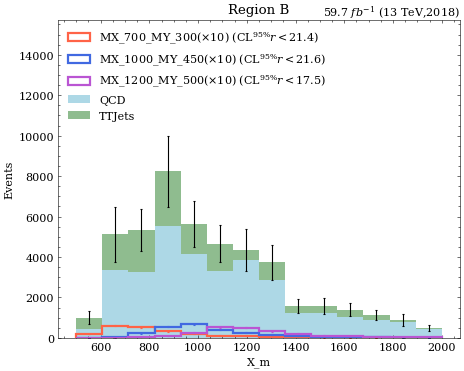

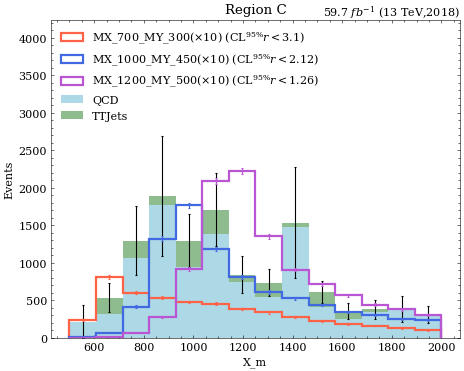

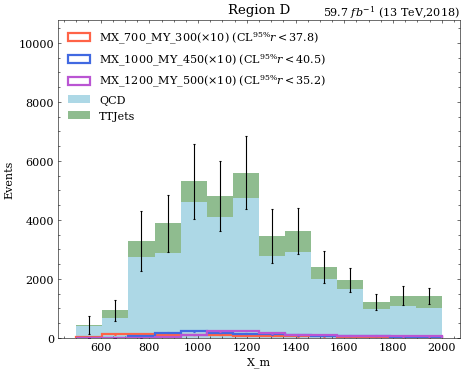

In [34]:
for r in ('a','b','c','d'):
    study.quick(
        signal + bkg, 
        legend=True,
        plot_scale=[10]*len(signal),
        masks=getattr(bdt,r),
        varlist=['X_m'],
        limits=True,
        title=f'Region {r.upper()}',
        saveas=f'{dout}/limits/region_{r}'
    )

In [35]:
bdt.train(bkg)
bdt.print_results(bkg)

--- ABCD Results ---
k = 3.061e-01
k*(b/a)-1  = -22.07%
BDT(b)/a-1 = -16.55%



100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


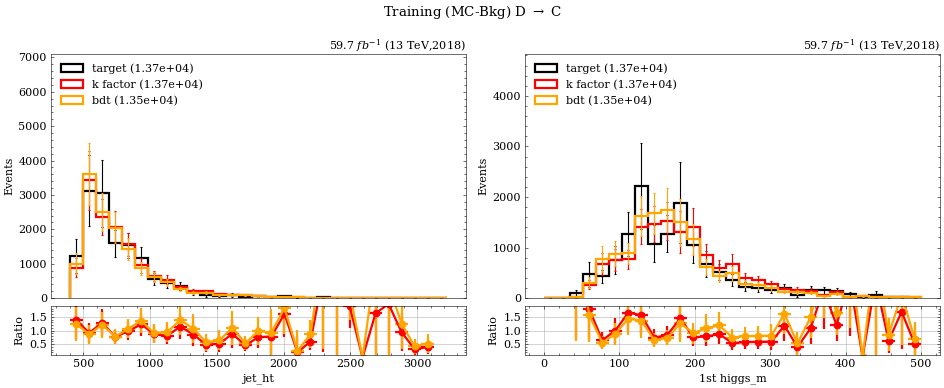

In [36]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','red','orange'], legend=True,
    masks=[bdt.c]*len(bkg)+[bdt.d]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Training (MC-Bkg) D $\\rightarrow$ C',
    ratio=True,
    saveas=f'{dout}/bdt/training'
)

100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


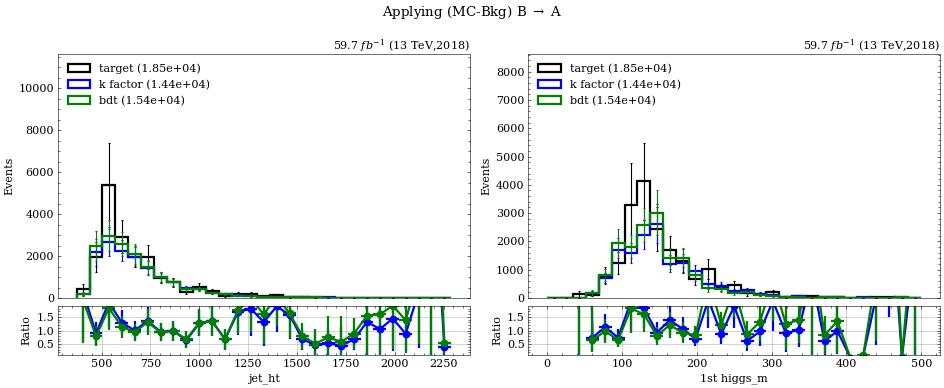

In [37]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[bdt.a]*len(bkg)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Applying (MC-Bkg) B $\\rightarrow$ A',
    saveas=f'{dout}/bdt/applying',
    ratio=True,
)

100%|██████████| 1/1 [00:14<00:00, 14.97s/it]


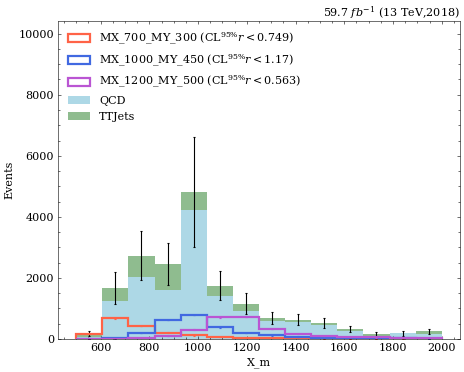

In [38]:
study.quick(
    signal + bkg, 
    legend=True,
    # plot_scale=[10]*len(signal),
    masks=bdt.a,
    varlist=['X_m'],
    limits=True,
)

100%|██████████| 1/1 [00:14<00:00, 14.16s/it]


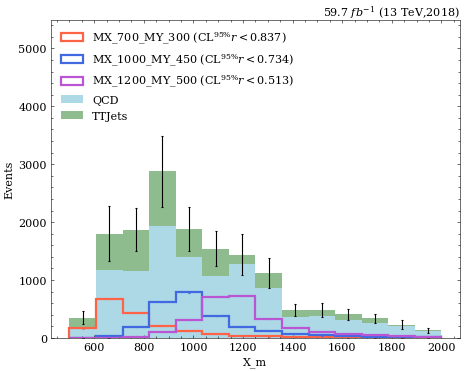

In [39]:
study.quick(
    signal + bkg, 
    legend=True,
    # plot_scale=[10]*len(signal),
    masks=[bdt.a]*len(signal)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(signal)+[bdt.reweight_tree]*len(bkg),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/bdt_bkg_model'
)